## DeepKriging + PS on Durham data

Let's test our DeepKriging model (which adjusts for preferential sampling via MSE+BCE loss function) on the Durham data.

In [1]:
# Load in the 7pm Durham data (over course of month of July 2023) on a half-km grid. Note that the observations are averaged (thanks Zach!)

import numpy as np

data = np.load('july2023_eve.npy')
# open up the data and see what's inside:

# Check the data's structure and basic characteristics
print("Data Type:", type(data))
print("Shape of the data:", data.shape)
print(data.dtype)
print("The data is plotted on a 109 x 76 grid, with each grid cell being a half-km square.")


Data Type: <class 'numpy.ndarray'>
Shape of the data: (109, 76)
float32
The data is plotted on a 109 x 76 grid, with each grid cell being a half-km square.


In [2]:
# Investigate how much of the data is missing:

print("Number of non-NaN values:", np.sum(~np.isnan(data)))
print("Number of NaN values:", np.sum(np.isnan(data)))

Number of non-NaN values: 88
Number of NaN values: 8196


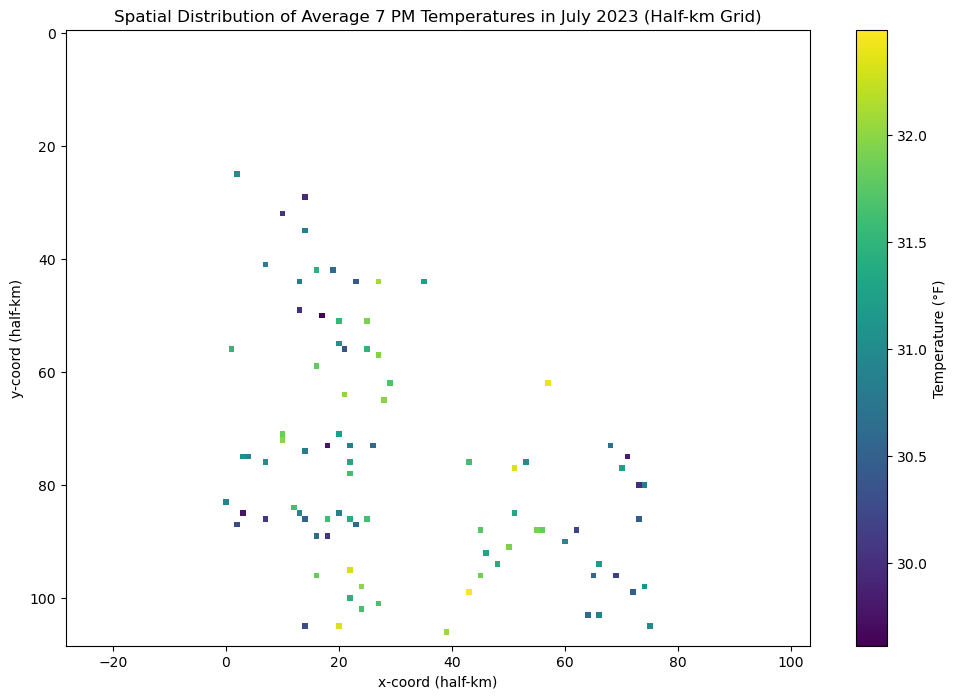

In [3]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
plt.imshow(data, cmap='viridis', aspect='equal')  # Adjust aspect to 'equal' to scale axes equally
plt.colorbar(label="Temperature (°F)")
plt.title("Spatial Distribution of Average 7 PM Temperatures in July 2023 (Half-km Grid)")
plt.xlabel("x-coord (half-km)")
plt.ylabel("y-coord (half-km)")
plt.axis('equal')  # Make x and y scales equal
plt.show()



In [ ]:
import numpy as np

# Load the data
data = np.load('july2023_eve.npy')

# Find non-NaN points and print them in the specified format
non_nan_points = []
for x in range(data.shape[0]):
    for y in range(data.shape[1]):
        if not np.isnan(data[x, y]):
            non_nan_points.append(((x, y), data[x, y]))

print(len(non_nan_points)) # This is how many observed points we have (88).

# Extract the coordinates of the observed points
# observed_coords = [point[0] for point in non_nan_points]
# for point in observed_coords:
#     print(point)
# print(len(observed_coords)) # This is how many observed points we have (88).

88


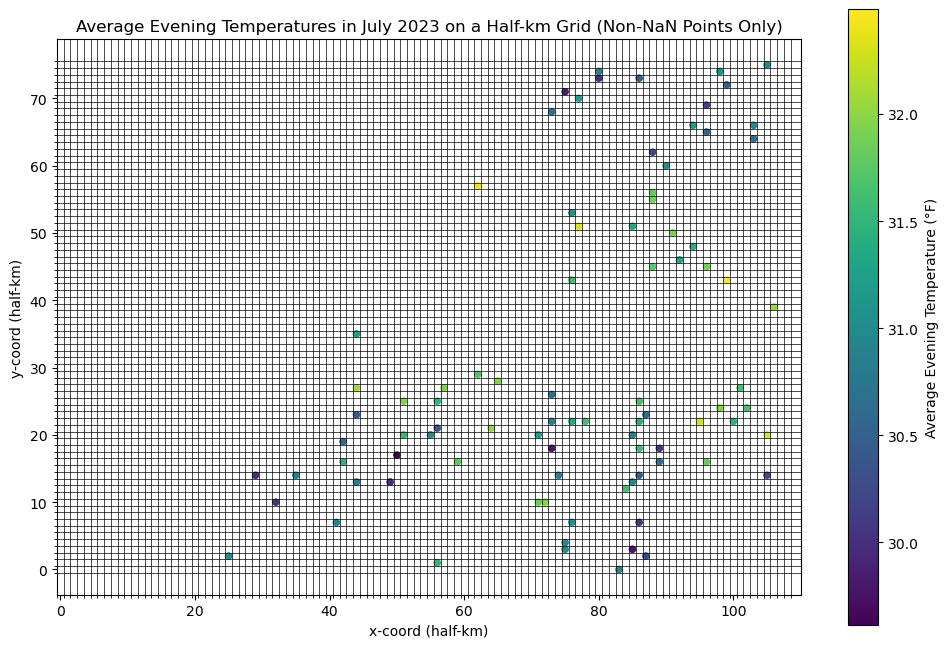

In [48]:
# Let's visualize the 109x76 grid overlaying the heatmap:

import numpy as np
import matplotlib.pyplot as plt

# Load the data
data = np.load('july2023_eve.npy')

# Create a figure
plt.figure(figsize=(12, 8))

# Plot only the non-NaN data points
x_coords, y_coords, values = [], [], []
for x in range(data.shape[0]):
    for y in range(data.shape[1]):
        if not np.isnan(data[x, y]):
            x_coords.append(x)
            y_coords.append(y)
            values.append(data[x, y])

# Convert to numpy arrays
x_coords = np.array(x_coords)
y_coords = np.array(y_coords)
values = np.array(values)

# Plot the non-NaN points with a scatter plot
sc = plt.scatter(x_coords, y_coords, c=values, cmap='viridis', s=20)
plt.colorbar(sc, label="Average Evening Temperature (°F)")

# Set grid lines to match the 109 x 76 grid structure
plt.gca().set_xticks(np.arange(-0.5, data.shape[0], 1), minor=True)
plt.gca().set_yticks(np.arange(-0.5, data.shape[1], 1), minor=True)
plt.grid(which="minor", color="black", linestyle='-', linewidth=0.5)

# Set aspect to equal for consistent cell dimensions
plt.gca().set_aspect('equal')

# Label axes and title
plt.title("Average Evening Temperatures in July 2023 on a Half-km Grid (Non-NaN Points Only)")
plt.xlabel("x-coord (half-km)")
plt.ylabel("y-coord (half-km)")

# Display the plot
plt.show()







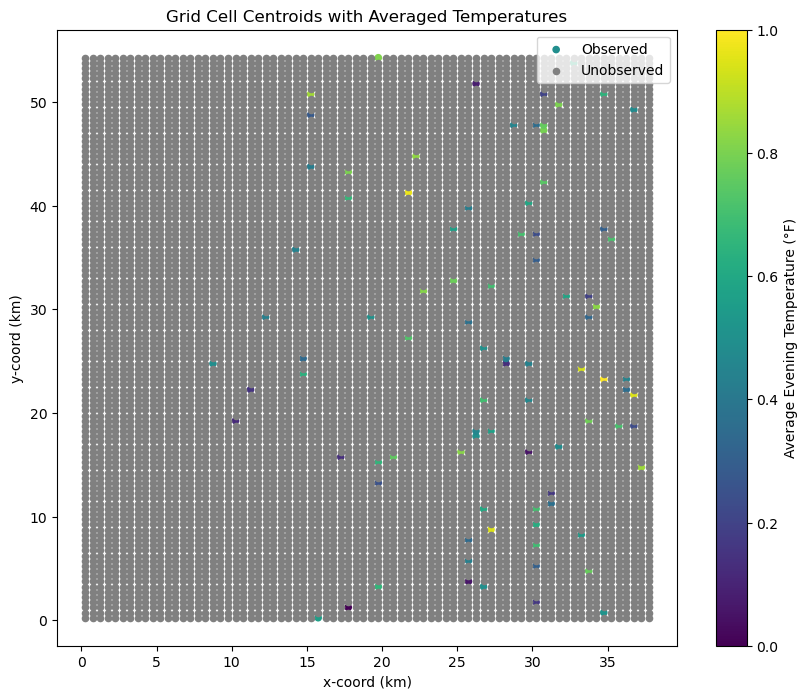

In [49]:
# Okay great, now that we've overlayed the half-km by half-km grid over the data we can
# plot the centroids and start plugging in the centroid data into the model.

# Let's start by plotting the centroids of the 109x76 grid:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
from itertools import product

data = np.load('july2023_eve.npy')

# Define grid dimensions
cells_y, cells_x = data.shape  # cells_y = 109, cells_x = 76 ??
resolution = 0.5  # Each cell represents a 0.5 km x 0.5 km area

# Calculate centroids
x_coords = np.arange(cells_x) * resolution + (resolution / 2)
y_coords = np.arange(cells_y) * resolution + (resolution / 2)
centroids = np.array(list(product(x_coords, y_coords)))

# Flatten the data to associate with centroids
flattened_data = data.ravel()  # Convert data to 1D array to match centroids

# Create a DataFrame with centroid coordinates and corresponding temperature values
df = pd.DataFrame({
    'temp_avg': flattened_data,
    'x': centroids[:, 0],
    'y': centroids[:, 1]
})

# Convert to GeoDataFrame
gdf = gpd.GeoDataFrame(
    df,
    geometry=gpd.points_from_xy(df['x'], df['y']),
    crs="EPSG:4326"  # Use the appropriate CRS; adjust if necessary
)

# Compute grid_row and grid_col for each point
gdf['grid_row'] = np.floor(gdf['y'] / resolution).astype(int)  # Use 'y' for grid_row
gdf['grid_col'] = np.floor(gdf['x'] / resolution).astype(int)  # Use 'x' for grid_col

# Separate observed (non-NaN) and unobserved (NaN) points
observed = gdf[~gdf['temp_avg'].isna()]  # Cells with observations
unobserved = gdf[gdf['temp_avg'].isna()]  # Cells without observations

# Plot the centroids with temperature data
plt.figure(figsize=(10, 8))
plt.scatter(observed['x'], observed['y'], c=observed['temp_avg'], cmap='viridis', s=20, label='Observed')
plt.scatter(unobserved['x'], unobserved['y'], color='gray', s=20, label='Unobserved')
plt.colorbar(label="Average Evening Temperature (°F)")
plt.xlabel("x-coord (km)")
plt.ylabel("y-coord (km)")
plt.title("Grid Cell Centroids with Averaged Temperatures")
plt.legend()
plt.show()

# Extract all observed coordinates as a NumPy array of (x, y) pairs
observed_coords = observed[['x', 'y']].to_numpy()

# Optionally, convert to a list of tuples
observed_coords_list = [tuple(coord) for coord in observed_coords]

# # Print the observed coordinates
# print("Observed Coordinates:")
# for coord in observed_coords_list:
#     print(coord)

/usr/local/Caskroom/miniforge/base/envs/torch-env/lib/python3.12/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/usr/local/Caskroom/miniforge/base/envs/torch-env/lib/python3.12/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/var/folders/nd/v9lp325j6vx2vr517r25j0q00000gn/T/ipykernel_40416/4259763825.py:45: UserWarning: Setting the 'color' property will over

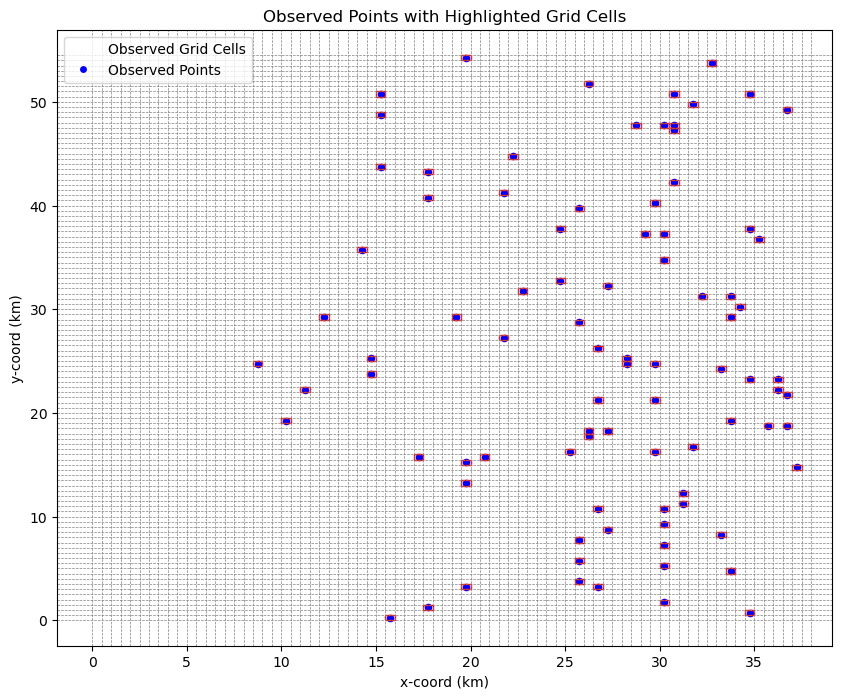

In [50]:
# Compute grid cell indices (row, col) for observed points
observed['grid_row'] = np.floor(observed['y'] / resolution).astype(int)
observed['grid_col'] = np.floor(observed['x'] / resolution).astype(int)

# Extract grid indices as a list of tuples
observed_grid_cell_indices = list(zip(observed['grid_row'], observed['grid_col']))

# Print the grid cell indices
# print("Observed Grid Cell Indices:")
# for index in observed_grid_cell_indices:
#     print(index)

import matplotlib.patches as patches

# Create a plot
fig, ax = plt.subplots(figsize=(10, 8))

# Plot observed points
plt.scatter(observed['x'], observed['y'], c='blue', label='Observed Points', s=20)

# Add grid lines
for i in range(cells_x + 1):
    plt.axvline(i * resolution, color='gray', linestyle='--', linewidth=0.5)
for j in range(cells_y + 1):
    plt.axhline(j * resolution, color='gray', linestyle='--', linewidth=0.5)

# Highlight observed grid cells
for _, row in observed.iterrows():
    # Calculate the grid cell boundaries
    x_left = row['grid_col'] * resolution  # Use 'grid_row' for x
    y_bottom = row['grid_row'] * resolution  # Use 'grid_col' for y

    # Add a rectangle to represent the observed grid cell
    rect = patches.Rectangle(
        (x_left, y_bottom), resolution, resolution, 
        linewidth=1, edgecolor='red', facecolor='none', label='Observed Grid Cell'
    )
    ax.add_patch(rect)

# Add labels and legend
plt.xlabel('x-coord (km)')
plt.ylabel('y-coord (km)')
plt.title('Observed Points with Highlighted Grid Cells')
plt.legend(handles=[
    patches.Patch(color='none', edgecolor='red', label='Observed Grid Cells'),
    plt.Line2D([0], [0], marker='o', color='w', label='Observed Points', markerfacecolor='blue', markersize=6)
])
plt.show()



Looks like our observed points lie within observed grid cells! Great! Which means that our ```observed_grid_indices``` contains the right indices!

In [51]:
from itertools import product

# Generate all possible grid cell indices
all_grid_cell_indices = set(product(range(cells_y), range(cells_x)))

# Convert observed grid indices to a set
observed_grid_cell_indices = set(zip(observed['grid_row'], observed['grid_col']))

# Compute unobserved grid cell indices using set difference
unobserved_grid_cell_indices = all_grid_cell_indices - observed_grid_cell_indices

# Convert to a sorted list for easier visualization (optional)
unobserved_grid_cell_indices = sorted(list(unobserved_grid_cell_indices))

# # Print the unobserved grid cell indices
# print("Unobserved Grid Cell Indices:")
# for index in unobserved_grid_cell_indices:
#     print(index)

print(len(unobserved_grid_cell_indices)) # Should be 8196


8196


In [52]:
# Let's open up Zach's ICAR+PS predictions:
icar_ps_data = np.load('ps_mu.npy')

# Open up the data and see what's inside:
print("Data Type:", type(icar_ps_data))
print("Shape of the data:", icar_ps_data.shape)
print(icar_ps_data.dtype)
print("The data is plotted on a 109 x 76 grid, with each grid cell being a half-km square.")


Data Type: <class 'numpy.ndarray'>
Shape of the data: (109, 76)
float64
The data is plotted on a 109 x 76 grid, with each grid cell being a half-km square.


Here's the game plan. We have the y_trues for the observed data points, but we are obviously missing the y_trues for the unobserved data points. This is where we'll use Zach Calhoun's ICAR+PS model predictions as "ground truth" values, so we can train our model in a way that minimizes loss. The goal of this is to see if we can recreate the same results as Zach's model.

In [53]:
print(len(unobserved_grid_cell_indices))

print(len(observed_grid_cell_indices))

8196
88


In [54]:
corner_temp_avg = gdf.query("grid_row == 0 and grid_col == 0")['temp_avg'].values

# Print the result
if len(corner_temp_avg) > 0:
    print(f"The temp_avg value for grid_row=0 and grid_col=0 is: {corner_temp_avg[0]}")
else:
    print("No matching row found for grid_row=0 and grid_col=0.")

The temp_avg value for grid_row=0 and grid_col=0 is: nan


In [55]:
# NB: Zach's ICAR+PS file contains a prediction for each grid cell in the 109x76 grid.

# Let's now set the unobserved grid cells in the gdf to the same values as the ICAR+PS predictions.
# We can do this by indexing into the gdf at the unobserved_grid_cell_indices and setting the 'temp_avg' column to the corresponding values in icar_ps_data.

# Create a copy of the original GeoDataFrame
gdf_new = gdf.copy()

# Iterate over unobserved grid cell indices and update `gdf_new`
num_matches = 0
for row, col in unobserved_grid_cell_indices:
    # Check if any row matches
    matches = gdf_new.loc[(gdf_new['grid_row'] == row) & (gdf_new['grid_col'] == col)]
    # if matches.empty:
    #     print(f"No match for grid_row={row}, grid_col={col}")
    # else:
    #     print(f"Match found for grid_row={row}, grid_col={col}")
    #     num_matches += 1
        
    # Get the prediction value from icar_ps_data for this grid cell
    predicted_value = icar_ps_data[row, col]
    
    # Update only unobserved cells
    gdf_new.loc[
        (gdf_new['grid_row'] == row) & 
        (gdf_new['grid_col'] == col) & 
        (gdf_new['temp_avg'].isna()), 
        'temp_avg'
    ] = predicted_value

# Let's check if that actually did what we want it to do:

# Count non-NaN rows in temp_avg
non_nan_count = gdf_new['temp_avg'].notna().sum()

# Total grid cells = observed + unobserved
expected_count = len(gdf)  # This should match the total number of rows in gdf_new

print(f"Non-NaN count in temp_avg: {non_nan_count}")
print(f"Total grid cells in gdf: {expected_count}")

if non_nan_count == expected_count:
    print("All grid cells have been successfully updated.")
else:
    print("Some grid cells still have NaN values.")



/var/folders/nd/v9lp325j6vx2vr517r25j0q00000gn/T/ipykernel_40416/2610583429.py:24: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '30.923366923049954' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  gdf_new.loc[


Non-NaN count in temp_avg: 8284
Total grid cells in gdf: 8284
All grid cells have been successfully updated.


In [56]:
temp_avg_value = gdf_new.query("grid_row == 0 and grid_col == 0")['temp_avg'].values

# Print the result
if len(temp_avg_value) > 0:
    print(f"The temp_avg value for grid_row=0 and grid_col=0 is: {temp_avg_value[0]}")
else:
    print("No matching row found for grid_row=0 and grid_col=0.")

The temp_avg value for grid_row=0 and grid_col=0 is: 30.923366923049954


In [57]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

import sys
import os

# Assuming the parent directory is one level up from the current script
parent_dir = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.insert(0, parent_dir)

# Now you can import from custom_dk_imports
from custom_dk_imports import DeepKrigingMLP, Trainer

# Define necessary parts from nn.py
class DeepKrigingEmbedding3d(nn.Module):
    def __init__(self, K: int):
        super(DeepKrigingEmbedding3d, self).__init__()
        self.K = K
        self.num_basis = [(9*2**(h-1)+1)**2 for h in range(1,self.K+1)]
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    def forward(self, s: torch.Tensor) -> torch.Tensor:
        knots_1d = [torch.linspace(0, 1, int(np.sqrt(i))).to(self.device) for i in self.num_basis]
        N = s.shape[0]
        phi = torch.zeros(N, sum(self.num_basis)).to(self.device)
        K = 0
        for res, num_basis_res in enumerate(self.num_basis):
            theta = 1 / np.sqrt(num_basis_res) * 2.5
            knots_s1, knots_s2 = torch.meshgrid(knots_1d[res], knots_1d[res], indexing='ij')
            knots = torch.stack((knots_s1.flatten(), knots_s2.flatten()), dim=1).to(self.device)
            d = torch.cdist(s, knots) / theta
            mask = (d >= 0) & (d <= 1)
            weights = torch.zeros_like(d)
            weights[mask] = ((1 - d[mask]) ** 6 * (35 * d[mask] ** 2 + 18 * d[mask] + 3) / 3)
            phi[:, K:K + num_basis_res] = weights
            K += num_basis_res
        return phi

In [58]:
import numpy as np
import torch
from sklearn.model_selection import train_test_split

import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

import sys
import os
# Get the absolute path of the parent directory
parent_dir = os.path.abspath(os.path.join(os.getcwd(), ".."))
# Add the parent directory to the Python path
sys.path.insert(0, parent_dir)
# Now you can import your module
from custom_dk_imports import DeepKrigingMLP, Trainer, NewLoss

grid_shape = (109, 76)  # Grid shape (rows, cols)


# RECALL: gdf_new is (grid_row, grid_col, temp_avg)

# Extract all coordinates and temp_avg values from gdf_new
grid_points = gdf_new[['x', 'y']].to_numpy()  # All grid points as (x, y) coordinates
temp_values = gdf_new['temp_avg'].to_numpy()  # Corresponding temperature values

# Convert observed/unobserved grid indices to arrays
observed_grid_cell_indices_array = np.array(list(observed_grid_cell_indices))  # Observed grid indices
unobserved_grid_cell_indices_array = np.array(list(unobserved_grid_cell_indices))  # Unobserved grid indices

# Map (row, col) to flattened indices
observed_flat_indices = np.ravel_multi_index(
    (observed_grid_cell_indices_array[:, 0], observed_grid_cell_indices_array[:, 1]),
    dims=(109, 76)
)
unobserved_flat_indices = np.ravel_multi_index(
    (unobserved_grid_cell_indices_array[:, 0], unobserved_grid_cell_indices_array[:, 1]),
    dims=(109, 76)
)

# Extract observed and unobserved points and values
observed_points = grid_points[observed_flat_indices]
observed_values = temp_values[observed_flat_indices]

unobserved_points = grid_points[unobserved_flat_indices]
unobserved_values = temp_values[unobserved_flat_indices]

# Verify the counts
print(f"Number of observed points: {len(observed_points)}")
print(f"Number of unobserved points: {len(unobserved_points)}")
print(f"Total grid cells: {len(grid_points)}")
assert len(observed_points) + len(unobserved_points) == len(grid_points), "Mismatch in total grid cells!"

# Define M as an indicator array for the entire grid
M = np.zeros(len(grid_points))
M[observed_flat_indices] = 1  # Mark observed points


Number of observed points: 88
Number of unobserved points: 8196
Total grid cells: 8284


In [59]:
s_train, s_val, y_train, y_val, M_train, M_val = train_test_split(grid_points, temp_values, M, test_size=0.2, random_state=2023)
s_test = grid_points  # Use the full grid as the test set

# Convert M_train and M_val back to torch tensors
M_train = torch.tensor(M_train, dtype=torch.float32)
M_val = torch.tensor(M_val, dtype=torch.float32)

# Define model parameters
num_hidden_layers = 1
hidden_dims = 100
K = 3  # embedding layer will update K based on DeepKrigingEmbedding3d

# Instantiate the embedding layer
embedding_layer = DeepKrigingEmbedding3d(K)
input_dim = sum(embedding_layer.num_basis)  # This should match 1830

# Normalize spatial coordinates
s_mean, s_std = grid_points.mean(axis=0), grid_points.std(axis=0)
s_train = (s_train - s_mean) / s_std
s_val = (s_val - s_mean) / s_std
s_test = (s_test - s_mean) / s_std

# Normalize temperature values
y_mean, y_std = temp_values.mean(), temp_values.std()
y_train = (y_train - y_mean) / y_std
y_val = (y_val - y_mean) / y_std
y_test = (temp_values - y_mean) / y_std

# Convert numpy arrays to torch tensors
s_train_tensor = torch.tensor(s_train, dtype=torch.float32)
s_val_tensor = torch.tensor(s_val, dtype=torch.float32)
s_test_tensor = torch.tensor(s_test, dtype=torch.float32)
s_all_tensor = torch.tensor(grid_points, dtype=torch.float32)
# print(s_train_tensor)

embedding_layer.eval()
# Compute the basis functions for each split using the tensor inputs
phi_train = embedding_layer(s_train_tensor)
phi_val = embedding_layer(s_val_tensor)
phi_test = embedding_layer(s_test_tensor)
phi_all = embedding_layer(s_all_tensor)

# Convert y_train, y_val, and y_test to torch tensors
y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
y_val = torch.tensor(y_val, dtype=torch.float32).view(-1, 1)
y_test = torch.tensor(temp_values, dtype=torch.float32).view(-1, 1)
y_all_tensor = torch.tensor(temp_values, dtype=torch.float32).view(-1, 1)


deepkriging_model = DeepKrigingMLP(input_dim, num_hidden_layers, hidden_dims, K=K, activation='relu')

train_loader = torch.utils.data.DataLoader(
    dataset=torch.utils.data.TensorDataset(phi_train, y_train),
    batch_size=32, shuffle=True
)

val_loader = torch.utils.data.DataLoader(
    dataset=torch.utils.data.TensorDataset(phi_val, y_val),
    batch_size=32, shuffle=False
)

test_loader = torch.utils.data.DataLoader(
    dataset=torch.utils.data.TensorDataset(phi_test, y_test),
    batch_size=32, shuffle=False
)

data_generators = {'train': train_loader, 'val': val_loader, 'test': test_loader}

from custom_dk_imports import NewLoss
trainer = Trainer(
    model=deepkriging_model,
    data_generators={'train': train_loader, 'val': val_loader, 'test': test_loader},
    optim='adam',
    optim_params={'lr': 0.001},
    loss_fn=NewLoss(s_all=grid_points, observed_indices=observed_flat_indices, y_all=temp_values),
    # loss_fn=nn.MSELoss(),
    M_train=M_train,
    M_val=M_val,
    window_size=10,
    device=torch.device('cuda' if torch.cuda.is_available() else 'cpu'),
    epochs=100,
    patience=10
)

trainer.train()

deepkriging_model.eval()

with torch.no_grad():
    y_pred_deepkriging = deepkriging_model(phi_all).cpu().numpy()

Training started:

Epoch 1/100
Learning rate: 0.001000
1s for 208 steps - 3ms/step - loss 1.5291
Validation:
0s - loss 1.4933

Epoch 2/100
Learning rate: 0.001000
1s for 208 steps - 3ms/step - loss 1.4554
Validation:
0s - loss 1.4834

Epoch 3/100
Learning rate: 0.001000
1s for 208 steps - 2ms/step - loss 1.4489
Validation:
0s - loss 1.4781

Epoch 4/100
Learning rate: 0.001000
0s for 208 steps - 2ms/step - loss 1.4454
Validation:
0s - loss 1.4747

Epoch 5/100
Learning rate: 0.001000
1s for 208 steps - 2ms/step - loss 1.4422
Validation:
0s - loss 1.4719

Epoch 6/100
Learning rate: 0.001000
1s for 208 steps - 2ms/step - loss 1.4399
Validation:
0s - loss 1.4755

Epoch 7/100
Learning rate: 0.001000
1s for 208 steps - 2ms/step - loss 1.4405
Validation:
0s - loss 1.4699

Epoch 8/100
Learning rate: 0.001000
0s for 208 steps - 2ms/step - loss 1.4363
Validation:
0s - loss 1.4689

Epoch 9/100
Learning rate: 0.001000
1s for 208 steps - 2ms/step - loss 1.4353
Validation:
0s - loss 1.4663

Epoch 10/

In [60]:
# Ask Zach how to display results in Map Format.

# Send the predictions back to the main script for visualization
